In [1]:
import torch
import numpy as np
import pandas as pd
import string
from datetime import datetime
from collections import Counter
from torch.utils.data import Dataset,DataLoader
from sklearn import manifold,metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from matplotlib import pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
#import ctypes
#ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

In [3]:
import kaldi_io

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [4]:
def filter_data(matrices,mat_lengths,keys, char_threshold = 5):
    '''Takes in matrices and keys. Filters the data by making all keys lowercase, removing words
    with number of letters less than a threshold.'''
    
    print('Length before filtering %d'%(len(keys)))
    #Lowercase all keys
    keys = list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower(),keys))
    
    #Filter if the characters are smaller than the character threshold
    matrices,mat_lengths,keys = zip(*filter(lambda x: len(x[2])>=char_threshold, zip(matrices,mat_lengths,keys)))
    
    matrices,mat_lengths,keys = list(matrices),list(mat_lengths),list(keys)
    
    print('Length after filtering %d'%(len(keys)))
    

    return matrices,mat_lengths,keys
    

In [5]:
# Function to truncate and limit dimensionality
def truncate_shapes(matrices,mat_lengths,max_length = 100,num_mfcc_features = 40):
    
    for i, seq in enumerate(matrices):
        matrices[i] = matrices[i][:max_length, :num_mfcc_features]
        mat_lengths[i] = min(mat_lengths[i], max_length)
    
    return matrices,mat_lengths 

In [6]:
#Function for padding
def pad_sequences(x, n_padded, center_padded=True):
    """Return the padded sequences and their original lengths."""
    padded_x = np.zeros((len(x), n_padded, x[0].shape[1]))
    lengths = []
    for i_data, cur_x in enumerate(x):
        length = cur_x.shape[0]
        if center_padded:
            padding = int(np.round((n_padded - length) / 2.))
            if length <= n_padded:
                padded_x[i_data, padding:padding + length, :] = cur_x
            else:
                # Cut out snippet from sequence exceeding n_padded
                padded_x[i_data, :, :] = cur_x[-padding:-padding + n_padded]
            lengths.append(min(length, n_padded))
        else:
            length = min(length, n_padded)
            padded_x[i_data, :length, :] = cur_x[:length, :]
            lengths.append(length)
    return padded_x, lengths

In [7]:
def generate_key_dicts_and_labels(keys):
    '''Arguments:
    keys : A list of words corresponding to the mfcc feature matrices
    -------------
    Returns:
    labels : A list of numbers correspoding to the words in the list keys'''
    c = Counter(keys)
    #print(c)
    num_words = len(c.keys())
    word_to_num = {}
    num_to_word = {}

    index = 0
    for key in c.keys():
        word_to_num[key] = index
        num_to_word[index] = key
        index+=1

    label_list = []
    for key in keys:
        label_list.append(word_to_num[key])

    print('Number of Unique words ',len(c.keys()))
    return c,word_to_num,num_to_word,label_list

In [8]:
#Load the data
keys = []
matrices = []
mat_lengths = []

number_list = [9,12,14,18,21,25,27,28]
load_list = ['Data/raw_mfcc_AMI_Segments.%d.scp'%(number) for number in number_list]
#load_list = ['Data/word_mfcc_features.ark']

for load_file in load_list:
    file_keys,file_matrices,file_mat_lengths = [],[],[]
    for key,matrix in kaldi_io.read_mat_scp(load_file):
    #for key,matrix in kaldi_io.read_mat_ark(load_file):
        file_keys.append(key.split('_')[1])
        file_matrices.append(matrix)
        file_mat_lengths.append(matrix.shape[0])
    #Filter the data
    file_matrices,file_mat_lengths,file_keys = filter_data(file_matrices,file_mat_lengths,file_keys,char_threshold = 5)
    
    #Add to the main list
    keys.extend(file_keys)
    matrices.extend(file_matrices)
    mat_lengths.extend(file_mat_lengths)
print(len(keys))

Length before filtering 10598
Length after filtering 5757
Length before filtering 10598
Length after filtering 5918
Length before filtering 10598
Length after filtering 5929
Length before filtering 10598
Length after filtering 5883
Length before filtering 10598
Length after filtering 5834
Length before filtering 10598
Length after filtering 5740
Length before filtering 10598
Length after filtering 5720
Length before filtering 10598
Length after filtering 5629
46410


In [9]:
#Filter the data
#matrices,mat_lengths,keys = filter_data(matrices,mat_lengths,keys,char_threshold = 5)

#Truncate the dimensions of the data
matrices,mat_lengths = truncate_shapes(matrices,mat_lengths,max_length=100,num_mfcc_features=40)
#Pad the matrices
matrices,mat_lengths = pad_sequences(matrices,n_padded = 100,center_padded = True)
matrices = np.transpose(matrices,(0,2,1))
#Generate keys and labels
c,word_to_num,num_to_word,label_list = generate_key_dicts_and_labels(keys)
#delete keys and mat_lengths
del keys,mat_lengths

Number of Unique words  5575


In [10]:
print(c)

Counter({'thats': 454, 'right': 450, 'think': 342, 'maybe': 333, 'because': 331, 'mmhmm': 329, 'something': 308, 'remote': 282, 'about': 277, 'buttons': 262, 'control': 244, 'really': 228, 'actually': 222, 'should': 216, 'people': 209, 'thing': 208, 'button': 206, 'things': 205, 'there': 197, 'design': 188, 'different': 184, 'probably': 181, 'which': 180, 'three': 171, 'alright': 167, 'could': 167, 'point': 165, 'meeting': 162, 'would': 161, 'screen': 159, 'channel': 149, 'rubber': 144, 'colour': 143, 'going': 139, 'quite': 136, 'other': 136, 'stuff': 134, 'recognition': 134, 'these': 132, 'still': 130, 'first': 130, 'market': 129, 'product': 128, 'basically': 127, 'functions': 127, 'gonna': 127, 'interface': 127, 'little': 122, 'problem': 120, 'project': 120, 'doesnt': 116, 'those': 115, 'colours': 114, 'theres': 111, 'exactly': 111, 'already': 111, 'display': 111, 'might': 110, 'anything': 110, 'volume': 110, 'scroll': 110, 'sorry': 110, 'important': 109, 'looking': 109, 'change': 10

In [11]:
print([(word,c[word]) for word in sorted(c.keys())])

[('abandoned', 1), ('abbreviations', 1), ('abigail', 1), ('ability', 6), ('about', 277), ('above', 11), ('abrupt', 1), ('absolute', 4), ('absolutely', 17), ('absorbers', 3), ('absorption', 5), ('abstract', 2), ('abstracts', 2), ('abundance', 1), ('abundances', 1), ('abutted', 1), ('academic', 1), ('accentuate', 2), ('accept', 1), ('acceptable', 3), ('acceptance', 1), ('access', 22), ('accessed', 1), ('accessible', 9), ('accessing', 1), ('accessoire', 1), ('accident', 1), ('accidentally', 6), ('accommodate', 1), ('accompanying', 1), ('accomplish', 1), ('accomplishing', 1), ('according', 21), ('accordingly', 3), ('account', 12), ('accounted', 2), ('accounting', 1), ('accounts', 2), ('accurate', 5), ('accurately', 3), ('accustomed', 1), ('achieve', 4), ('achieved', 4), ('acknowledge', 1), ('acknowledged', 1), ('acoustic', 1), ('acquaintance', 1), ('acquainted', 3), ('acronym', 1), ('acronyms', 1), ('across', 14), ('acting', 1), ('action', 14), ('actions', 14), ('activate', 5), ('activated

In [12]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
inputs = np.stack(matrices)
del matrices
#inputs = np.expand_dims(inputs,1)
labels = np.array(label_list)
del label_list
print(inputs.shape)
print(labels.shape)

(46410, 40, 100)
(46410,)


In [14]:
x_trainval,x_test,y_trainval,y_test = train_test_split(inputs, labels, test_size=0.2, random_state=42)

In [15]:
x_train,x_val,y_train,y_val = train_test_split(x_trainval,y_trainval,test_size =0.25, random_state = 42)

In [16]:
x_train,y_train = torch.tensor(x_train,dtype= torch.float),torch.tensor(y_train, dtype= torch.float)
x_val,y_val = torch.tensor(x_val, dtype= torch.float),torch.tensor(y_val, dtype= torch.float)
x_test,y_test = torch.tensor(x_test, dtype= torch.float),torch.tensor(y_test, dtype= torch.float)

In [17]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

torch.Size([27846, 40, 100]) torch.Size([27846])
torch.Size([9282, 40, 100]) torch.Size([9282])
torch.Size([9282, 40, 100]) torch.Size([9282])


In [35]:
yc = Counter([num_to_word[y_test[i].item()] for i in range(0,y_test.shape[0]) ])

In [40]:
yc["talking"]

14

In [45]:
c['named']

4

In [44]:
#sorted(yc,key = lambda x: x[1])
print([(word[0],yc[word[0]]) for word in sorted(yc.items(),key = lambda x: x[1])])

[('named', 1), ('grandad', 1), ('expanding', 1), ('redesign', 1), ('campaign', 1), ('manufacturer', 1), ('cleaning', 1), ('crocodile', 1), ('skipping', 1), ('candy', 1), ('varying', 1), ('booming', 1), ('perform', 1), ('jonathan', 1), ('characteristics', 1), ('screw', 1), ('kickoff', 1), ('wierd', 1), ('wishing', 1), ('logical', 1), ('forbid', 1), ('weigh', 1), ('hangs', 1), ('curviness', 1), ('colouring', 1), ('played', 1), ('diagonal', 1), ('congratulate', 1), ('webmail', 1), ('consensus', 1), ('attached', 1), ('visualise', 1), ('trouble', 1), ('tiger', 1), ('argument', 1), ('database', 1), ('rigid', 1), ('heading', 1), ('interim', 1), ('displays', 1), ('intervene', 1), ('whichever', 1), ('cafeteria', 1), ('reiteration', 1), ('visuals', 1), ('hooked', 1), ('describing', 1), ('nobodys', 1), ('bursts', 1), ('itemize', 1), ('impractical', 1), ('sticker', 1), ('deciding', 1), ('writings', 1), ('describes', 1), ('jumbo', 1), ('chair', 1), ('refuses', 1), ('everybodyll', 1), ('counting', 1

In [18]:
x_train[20].squeeze()[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 71.4935,
        72.3981, 80.2547, 81.3561, 83.9534, 85.2806, 82.7921, 82.4603, 81.5764,
        80.9156, 81.9626, 82.1285, 81.7967, 81.5030, 80.6953, 76.2897, 72.4715,
        67.1515, 64.9805, 61.9049, 60.8193, 80.9890,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

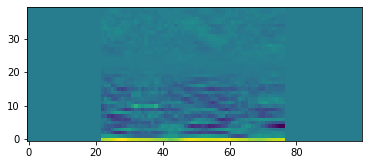

In [19]:
plt.imshow(x_train[10].squeeze(), origin = "bottom")

In [20]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, pin_memory = True)

val_ds = TensorDataset(x_val, y_val)
val_dl = DataLoader(val_ds, batch_size=bs, pin_memory = True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs, pin_memory = True)

In [23]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv1d(40,96,(10))
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(96, 96, (8))
        self.fc1 = nn.Linear(672, 1024)
        self.fc2 = nn.Linear(1024, len(c.keys()))
        self.sm = nn.Softmax(dim = 1)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('Pre')
        #print(x.shape)  
        x = x.view(x.shape[0], -1)
        #print('Post')
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.log_softmax(x,dim=1)
        #print(x.shape)
        #print("Done")
        return x
    
    def give_embeddings(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('Pre')
        #print(x.shape)  
        x = x.view(x.shape[0], -1)
        #print('Post')
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        return x.cpu().detach().numpy() if dev.type == 'cuda' else x.detach().numpy()




In [24]:
#net = SimpleNet()
net = SimpleNet()
net = net.float()
net.to(dev)

SimpleNet(
  (conv1): Conv1d(40, 96, kernel_size=(10,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(96, 96, kernel_size=(8,), stride=(1,))
  (fc1): Linear(in_features=672, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5575, bias=True)
  (sm): Softmax(dim=1)
)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [26]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [27]:
def train_model(net,num_epochs,train_dl,val_dl,save_path = "./Models/"):
    
    best_val_loss = np.Inf
    best_val_acc = np.NINF
    for epoch in range(0,num_epochs):  # loop over the dataset multiple times
        print('epoch %d '%(epoch))

        train_loss = 0
        train_acc = 0
        net.train()
        for xb,yb in train_dl:
            
            #Move to GPU
            xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
            
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = torch.tensor(inputs),torch.tensor(labels)
            #labels = labels.long()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(xb)
            loss = criterion(outputs, yb.long())
            train_loss += loss.item()
            train_acc += accuracy(outputs,yb)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss = loss.item()
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for xb,yb in val_dl:
                
                #Move to GPU
                xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
                
                #get predictions
                y_pred = net(xb)
                
                val_loss += criterion(y_pred,yb.long())
                val_acc += accuracy(y_pred, yb.long())
            #val_loss = sum(criterion(net(xb), yb.long()) for xb, yb in val_dl)
            #val_acc = sum(accuracy(net(xb), yb.long()) for xb, yb in val_dl)
            if val_acc.cpu().detach().numpy() > best_val_acc:
                best_val_acc = val_acc.cpu().detach().numpy()
                path = save_path + "best_model.pth"
                print("Best val acc. Saving model...")
                torch.save(net.state_dict(), path)


        print("train loss: %.3f train acc: %.3f"%(train_loss/len(train_dl),train_acc/len(train_dl)))
        print("val loss: %.3f val acc: %.3f"%(val_loss/len(val_dl),val_acc/len(val_dl)))
        if epoch%5 == 0:
            path = save_path + "simple_awe_bs64_epoch_%d.pth"%(epoch)
            torch.save(net.state_dict(), path)


    print('Finished Training')

In [28]:
def evaluate_model(net,test_dl, diagonal_pairs = True):
    
    embeddings = None
    labels = None
    for xb,yb in test_dl:
        if xb.shape[0]<64:
            continue
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
            
        #Get the embeddings
        batch_embeddings = net.give_embeddings(xb)
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
            labels = np.concatenate((labels,yb),axis=0)
        else:
            embeddings = batch_embeddings
            labels = yb


    
    #Calculate pairwise cosine distance
    distances = pairwise_distances(embeddings, metric='cosine')
    #Calculate pairwise cosine similarity
    similarity = pairwise_kernels(embeddings, metric = 'cosine')
    
    
    
    #Create labels of whether the words are same or not
    if torch.is_tensor(labels):
        labels = labels.detach().numpy()
        
    eval_labels = (labels[:,None]==labels).astype(float)
    
    
    if not diagonal_pairs:
        #Remove the diagonal elements (word pairs with themselves)
        mask = np.array(np.tril(np.ones((similarity.shape[0],similarity.shape[0])),-1),dtype = bool)
        similarity = similarity[mask]
        distances = distances[mask]
        eval_labels = eval_labels[mask]
        
    #flatten the pairwise arrays
    distances = np.ravel(distances)
    similarity = np.ravel(similarity)
    #Flatten the labels
    eval_labels = np.ravel(eval_labels)
    
    num_positive = sum(eval_labels==1)
    num_negative = eval_labels.shape[0]-num_positive
    print('The number of positive examples %d and negative examples %d'%(num_positive,num_negative))
    #Calculate the Average Precision
    #avg_p = average_precision_score(eval_labels,similarity)
    avg_p = average_precision_score(eval_labels,2-distances)
    #avg_p = average_precision_score(eval_labels,2-distances)
    print('Average Precision is %f'%(avg_p))

            
            

In [29]:
train = False

In [30]:
if train:
    train_model(net,100,train_dl,val_dl,save_path="./Models/")
else:
    print('Not training the model')

Not training the model


In [31]:
#Load the best model
best_model_path = "./Models/best_model.pth"
net.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [32]:
print(dev.type == 'cuda')

True


In [34]:
test_acc = 0
if dev.type == 'cuda':
    for xb,yb in test_dl:
        if xb.shape[0]<64:
            continue
        #Move to GPU
        xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
        y_pred = net(xb)
        test_acc += accuracy(y_pred,yb.long())
    test_acc = test_acc/len(test_dl)
elif dev.type == 'cpu':
    for xb,yb in test_dl:
        if xb.shape[0]<64:
            continue
        y_pred = net(x_test)
        test_acc += accuracy(y_pred,yb.long())
    test_acc = test_acc/len(test_dl)
    
print("Test Accuracy of best model is %.3f"%(test_acc))

Test Accuracy of best model is 0.362


In [33]:
evaluate_model(net,test_dl,diagonal_pairs = False)

The number of positive examples 70287 and negative examples 42984273
Average Precision is 0.059762


In [41]:
train_words = set([num_to_word[y_train[i].item()] for i in range(y_train.shape[0])])
val_words = set([num_to_word[y_val[i].item()] for i in range(y_val.shape[0])])
test_words = set([num_to_word[y_test[i].item()] for i in range(y_test.shape[0])])

In [42]:
def give_tsne(net,inputs):
    
    if dev.type == 'cuda':
        inputs = inputs.to(dev, non_blocking = True)
    embeddings = net.give_embeddings(inputs)
    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    tsne_vectors = tsne.fit_transform(embeddings)
    
    return tsne_vectors


In [43]:
def add_membership(word):
    train_tag = "Tr" if word in train_words else ""
    val_tag = "|Val" if word in val_words else ""
    test_tag = "|Ts" if word in test_words else ""
    return word+" (%s%s%s)"%(train_tag,val_tag,test_tag)

In [44]:
def visualize_words(word_list,tsne_vectors,labels,rigid_limits = False):
    #Get ids of words from labels
    num_list = [word_to_num[word] for word in word_list]
    ids = np.where(np.isin(labels,np.array(num_list)))
    
    df_subset = {}
    df_subset['tsne-2d-one'] = tsne_vectors[ids][:,0]
    df_subset['tsne-2d-two'] = tsne_vectors[ids][:,1]
    df_subset['Word'] = [num_to_word[labels[ids][i].item()] for i in range(ids[0].shape[0])]
    
    #Convert to dataframe
    df_subset = pd.DataFrame(df_subset)
    #Add membership tags
    df_subset['Word'] = df_subset['Word'].apply(add_membership)
    
    #print(df_subset['tsne-2d-one'].shape)
    #print(df_subset['tsne-2d-two'].shape)
    #print(len(df_subset['y']))
    
    #print(ids)
    #print(df_subset['y'])
    
    g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Word",
    data=df_subset,
    legend="full",
    alpha=0.5)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    if rigid_limits:
        x_coordinate = tsne_vectors[:,0]
        y_coordinate = tsne_vectors[:,1]
        epsilon = 5
        plt.xlim(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
        plt.ylim(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)
    

In [45]:
tsne_vectors = give_tsne(net,torch.tensor(inputs,dtype=torch.float))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3449 samples in 0.923s...
[t-SNE] Computed neighbors for 3449 samples in 17.629s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3449
[t-SNE] Computed conditional probabilities for sample 2000 / 3449
[t-SNE] Computed conditional probabilities for sample 3000 / 3449
[t-SNE] Computed conditional probabilities for sample 3449 / 3449
[t-SNE] Mean sigma: 31.335456
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.774117
[t-SNE] KL divergence after 500 iterations: 1.728038


In [46]:
x_coordinate = tsne_vectors[:,0]
y_coordinate = tsne_vectors[:,1]
epsilon = 5
print(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
print(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)

-53.61260223388672 48.65258026123047
-37.48564147949219 45.11390686035156


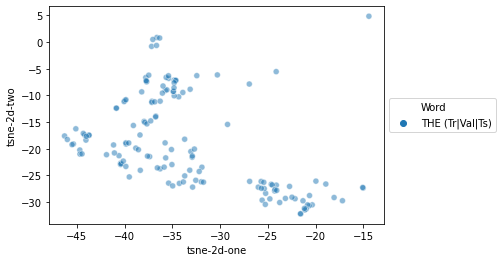

In [47]:
word_list = ["THE"]
visualize_words(word_list,tsne_vectors,labels)

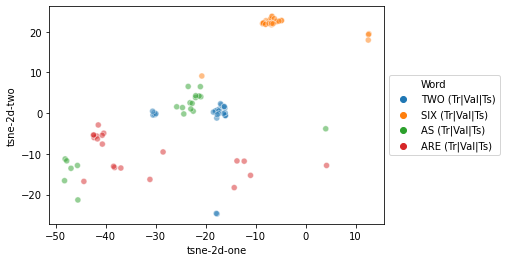

In [48]:
word_list = ["AS","ARE","TWO","SIX"]
visualize_words(word_list,tsne_vectors,labels)

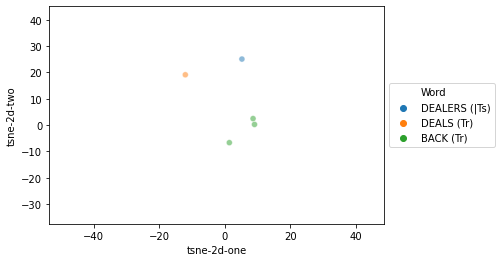

In [49]:
word_list = ["DEALERS","DEALS","BACK"]
visualize_words(word_list,tsne_vectors,labels,True)

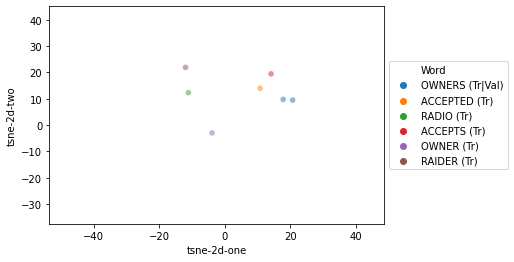

In [50]:
word_list = ["ACCEPTED","ACCEPTS","RADIO","RAIDER","OWNER","OWNERS"]
visualize_words(word_list,tsne_vectors,labels,True)

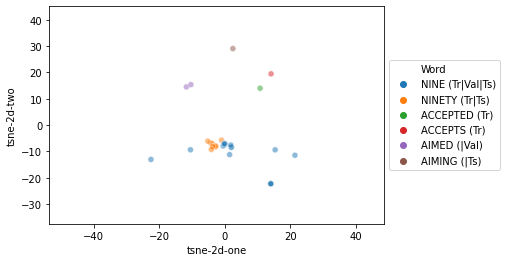

In [51]:
word_list = ["NINE","NINETY","ACCEPTED","ACCEPTS","AIMED","AIMING"]
visualize_words(word_list,tsne_vectors,labels,True)

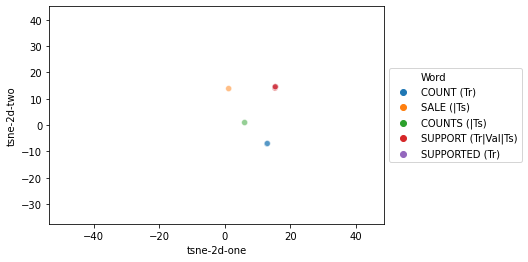

In [52]:
word_list = ["COUNT","COUNTS","SALE","SUPPORT","SUPPORTED"]
visualize_words(word_list,tsne_vectors,labels,True)

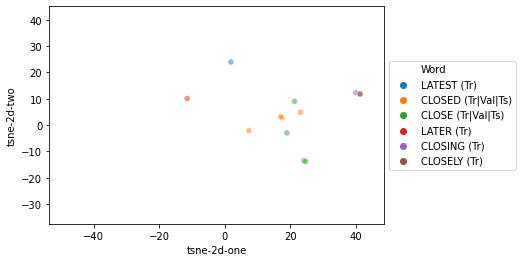

In [53]:
word_list = ["LATER","LATEST","CLOSE","CLOSING","CLOSED","CLOSELY"]
visualize_words(word_list,tsne_vectors,labels,True)

In [54]:
def nearest_neighbors(net,inputs,labels,n_neighbors = 3):
    
    if dev.type == 'cuda':
        inputs = inputs.to(dev, non_blocking = True)
    embeddings = net.give_embeddings(inputs)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute',metric = 'cosine').fit(embeddings)
    distances,indices = nbrs.kneighbors(embeddings)
    
    return distances,indices
    

In [55]:
def nearest_neighbors_for_word(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [56]:
distances,indices = nearest_neighbors(net,torch.tensor(inputs,dtype=torch.float),labels,n_neighbors=5)

In [57]:
word = "SUPPORT"
nearest_neighbors_for_word(word,indices,labels)

['SUPPORT', 'REPORTED', 'DECLINED', 'SUPPORT', 'SUPPORTED']
['SUPPORT', 'SUPPORT', 'DOUBLED', 'SUPPORTED', 'UNSOLD']
['SUPPORT', 'SUPPORT', 'SUPPORTED', 'RESTORE', 'SUPPORT']


In [58]:
word = "LATER"
nearest_neighbors_for_word(word,indices,labels)

['LATER', 'RADIO', 'NEEDED', 'UNDER', 'NEW']


In [59]:
word = "CLOSING"
nearest_neighbors_for_word(word,indices,labels)

['CLOSING', 'ELECTION', 'ELECTION', 'CLOSELY', 'CLOSELY']


In [60]:
word = "ACCEPTED"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTED', 'EXPECTED', 'ACCEPTS', 'SPECIFICALLY', 'INCENTIVES']


In [61]:
word = "DEALS"
nearest_neighbors_for_word(word,indices,labels)

['DEALS', 'BIDS', 'YIELDS', 'JUST', 'YIELD']


In [62]:
word = "RANGE"
nearest_neighbors_for_word(word,indices,labels)

['RANGE', 'GAINS', 'EIGHTH', 'GAINS', 'AIMED']
['RANGE', 'MANY', 'RANGED', 'CANADIAN', 'UNION']
['RANGE', 'ARRANGED', 'BRADY', 'GAIN', "MONDAY'S"]


In [63]:
word = "DAY"
nearest_neighbors_for_word(word,indices,labels)

['DAY', 'BIG', 'NEW', 'EIGHTY', 'BE']
['DAY', 'MAY', 'AIMING', 'EIGHTH', 'NINETEEN']
['DAY', 'MAY', 'IN', 'END', 'BID']
['DAY', 'YOU', 'THEIR', 'EIGHT', 'MILLION']


In [64]:
word = "CARE"
nearest_neighbors_for_word(word,indices,labels)

['CARE', 'YEAR', 'DO', 'TERM', 'YEAR']
['CARE', 'CARE', 'TERM', 'TERM', 'SHOW']
['CARE', 'THERE', 'FOUR', 'CARE', 'SHARE']


In [65]:
def filter_infrequent_words(labels,threshold = 2):
    '''For a given list of labels, returns index of frequent words 
    (words having frequency greater than or equal to the threshold)
    '''
    if torch.is_tensor(labels):
        label_counter = Counter(labels.detach().numpy())
    else:
        label_counter = Counter(labels)
    print('Number of unique words in labels %d'%(len(word_counter)))
    
    #Remove infrequent words from the Counter
    for key,value in tuple(label_counter.items()):
        if not (value>=threshold):
            label_counter.pop(key)
    print('Number of unique words with frequency atleast %d is %d'%(threshold,len(word_counter)))
    
    #Get the labels for the frequent words
    frequent_word_labels = np.array(tuple(label_counter.keys()))
    frequent_word_indices = np.where(np.isin(labels,frequent_word_labels))
    
    return frequent_word_indices,frequent_word_labels

In [66]:
#frequent_word_indices,frequent_word_labels = filter_infrequent_words(y_train)